In [2]:
import sys

sys.path.append("../")

DATA_PATH = '/mnt/d/Working/PersonalProjects/Trading/trading-agent/crypto-pair-trading/data/crypto/1h'

In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from stats_arb.tests import adf_test, kpss_test, cal_half_life, pp_test
from datetime import datetime, timedelta
import itertools as it
import backtrader as bt

import empyrical
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)
plt.ioff()

In [4]:
# symbols = pd.read_csv(f'{DATA_PATH}/../symbols.csv')['symbol'].values.tolist()
symbols = ['BTC', 'ETH', 'ADA', 'BNB', 'SOL', 'XRP', 'DOT', 'LINK', 'BCH', 'LTC', 'ALGO', 'MATIC', 'XLM', 'ETC']
symbols = [f'{s}-USDT' for s in symbols]

def get_data(start_date, end_date, use_log=True):
    data = []
    for symbol in symbols:
        try:
            file = f'{DATA_PATH}/{symbol}.csv'
            # print(file)
            df = pd.read_csv(file, 
                            parse_dates=['open_time'], 
                            index_col=['open_time'])
            df = df[(df.index > start_date) & (df.index < end_date)]
            df = df[~df.index.duplicated(keep='first')]
            df.rename(columns={'close': symbol}, inplace=True)
            if use_log:
                # the data is too long, just limit to recent period
                data.append(np.log(df[symbol]))
            else:
                data.append(df[symbol])
        except:
            pass

    df = pd.concat(data, axis=1)
    df = df.dropna(axis=1, how='all')
    df.dropna(inplace=True, how='any')

    return df

In [5]:
p = 1
COINTEGRATION_CONFIDENCE_LEVEL = 90

# the 90%, 95%, and 99% confidence levels for the trace statistic and maximum 
# eigenvalue statistic are stored in the first, second, and third column of 
# cvt and cvm, respectively
confidence_level_cols = {
    90: 0,
    95: 1,
    99: 2
}
confidence_level_col = confidence_level_cols[COINTEGRATION_CONFIDENCE_LEVEL]


def test_johansen(df, symbol_pairs):
    cointegrating_pairs = []
    df_t = df[symbol_pairs].copy()
    df_t.dropna(inplace=True)

    # The second and third parameters indicate constant term, with a lag of 1. 
    result = coint_johansen(df_t, 0, p)

    trace_crit_value = result.cvt[:, confidence_level_col]
    eigen_crit_value = result.cvm[:, confidence_level_col]
    #     print("trace_crit_value",trace_crit_value)
    #     print("eigen_crit_value",eigen_crit_value)
    #     print("lr1",result.lr1)
    #     print("lr2",result.lr2)

    # The trace statistic and maximum eigenvalue statistic are stored in lr1 and lr2;
    # see if they exceeded the confidence threshold
    if np.all(result.lr1 >= trace_crit_value) and np.all(result.lr2 >= eigen_crit_value):
        # print(f"{symbol_pairs} are cointegrated")
        # The first i.e. leftmost column of eigenvectors matrix, result.evec, contains the best weights.
        v1= result.evec[:,0:1]
        hr=v1/-v1[1] #to get the hedge ratio divide the best_eigenvector by the negative of the second component of best_eigenvector
        #the regression will be: close of symbList[1] = hr[0]*close of symbList[0] + error
        #where the beta of the regression is hr[0], also known as the hedge ratio, and
        #the error of the regression is the mean reverting residual signal that you need to predict, it is also known as the "spread"
        #the spread = close of symbList[1] - hr[0]*close of symbList[0] or alternatively (the same thing):
        #do a regression with close of symbList[0] as x and lose of symbList[1] as y, and take the residuals of the regression to be the spread.
        coint_pair = dict(hedge_ratio=v1[:, 0])
        for i, s in enumerate(symbol_pairs):
            coint_pair[f'sid_{i+1}'] = s

        cointegrating_pairs.append(coint_pair)
    
    return cointegrating_pairs



In [6]:
import traceback


critical_val = 0.005


def calculate_spread(df, coint_df, nb_symbols, selected_row, hedge_ratio):
    spread = None
    for i in range(nb_symbols):
        if spread is None:
            spread = df[coint_df[f'sid_{i + 1}'].iloc[selected_row]] * hedge_ratio[i]
        else:
            spread += df[coint_df[f'sid_{i + 1}'].iloc[selected_row]] * hedge_ratio[i]
    
    spread.dropna(inplace=True)
    return spread


def find_stationary_portfolio(df, coint_df, nb_symbols):
    data = []
    for i, _ in coint_df.iterrows():
        try:
            hedge_ratio = coint_df.iloc[i]['hedge_ratio']
            spread = calculate_spread(df, coint_df, nb_symbols, i, hedge_ratio)
                
            half_life = cal_half_life(spread)
            pairs_name = coint_df[[col for col in coint_df.columns if col != 'hedge_ratio']].iloc[i].values
            # print(i, pairs_name, 'is stationary with half life', half_life)
            # print(' ')
            data.append({
                'i': i,
                'pairs': pairs_name,
                'half_life': half_life
            })
        except:
            traceback.print_exc()
    
    stationary_df = pd.DataFrame(data)
    if len(stationary_df) > 0:
        stationary_df.sort_values(by=['half_life'], inplace=True)
    return stationary_df


# find_stationary_portfolio(df, coint_df, nb_symbols)


In [124]:
def zscore(x: pd.Series, window: int):
    r = x.rolling(window=window)
    m = r.mean()
    s = r.std(ddof=0)
    z = (x-m)/s
    return z

In [125]:
start_date = '2021-04-01'
end_date = '2021-08-30'


df = get_data(start_date, end_date)
df.head()

,BTC-USDT,ETH-USDT,ADA-USDT,BNB-USDT,SOL-USDT,XRP-USDT,DOT-USDT,LINK-USDT,BCH-USDT,LTC-USDT,ALGO-USDT,MATIC-USDT,XLM-USDT,ETC-USDT
open_time,,,,,,,,,,,,,,
2021-04-01 01:00:00,10.989311,7.571937,0.176689,5.726812,2.971132,-0.543349,3.599228,3.397892,6.309573,5.295162,0.327359,-1.009997,-0.878995,2.657458
2021-04-01 02:00:00,10.988548,7.564716,0.177543,5.729726,2.976126,-0.546971,3.597285,3.392056,6.303699,5.292350,0.314446,-0.975457,-0.881286,2.662355
2021-04-01 03:00:00,10.989014,7.563564,0.174793,5.726212,2.986444,-0.554081,3.595804,3.392762,6.296630,5.288318,0.309835,-0.988163,-0.886489,2.645820
2021-04-01 04:00:00,10.984216,7.559820,0.179818,5.725466,3.006860,-0.557393,3.600321,3.389395,6.293438,5.281731,0.312399,-0.976253,-0.888043,2.643974
2021-04-01 05:00:00,10.983045,7.556794,0.175901,5.721557,2.999993,-0.564754,3.607154,3.384289,6.284246,5.279848,0.296840,-1.001495,-0.897788,2.649997


In [126]:
import traceback


nb_symbols = 3

#get symbol pairs
pairs = list(it.combinations(symbols, nb_symbols))
cointegrating_pairs = []

for pair in pairs:
    try:
        result = test_johansen(df, list(pair))
    except Exception:
        # traceback.print_exc()
        result = []

    cointegrating_pairs.extend(result)

coint_df = pd.DataFrame(cointegrating_pairs)
coint_df.head()

,hedge_ratio,sid_1,sid_2,sid_3
0,"[8.196061951613034, 0.25344699632497003, -5.17...",BTC-USDT,ETH-USDT,BNB-USDT
1,"[9.981957466509213, 0.3484250735484659, -4.202...",BTC-USDT,ETH-USDT,DOT-USDT
2,"[9.195293658947712, -2.3106224826015134, -8.65...",BTC-USDT,ETH-USDT,ALGO-USDT
3,"[7.343498558691784, -5.423468416736351, 1.2711...",BTC-USDT,BNB-USDT,LTC-USDT
4,"[6.5749312766130075, -6.161191141202442, 2.552...",BTC-USDT,BNB-USDT,ALGO-USDT


In [127]:
stationary_df = find_stationary_portfolio(df, coint_df, nb_symbols)
stationary_df

/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,i,pairs,half_life
25,25,"[ALGO-USDT, MATIC-USDT, XLM-USDT]",47
13,13,"[BTC-USDT, DOT-USDT, ALGO-USDT]",55
15,15,"[BTC-USDT, LTC-USDT, ALGO-USDT]",59
17,17,"[BTC-USDT, LTC-USDT, XLM-USDT]",62
24,24,"[BCH-USDT, ALGO-USDT, MATIC-USDT]",70
21,21,"[XRP-USDT, BCH-USDT, XLM-USDT]",84
22,22,"[XRP-USDT, ALGO-USDT, XLM-USDT]",100
2,2,"[BTC-USDT, ETH-USDT, ALGO-USDT]",120
19,19,"[BNB-USDT, ALGO-USDT, MATIC-USDT]",125
10,10,"[BTC-USDT, XRP-USDT, MATIC-USDT]",130


In [128]:
i = 15
selected = coint_df.iloc[i].to_dict()
selected['pair'] = list(stationary_df.loc[i].pairs)
selected['half_life'] = stationary_df.loc[i].half_life
# stationary_df.loc[i]
selected

{'hedge_ratio': array([  2.05415654,   7.52698081, -13.97296631]),
 'sid_1': 'BTC-USDT',
 'sid_2': 'LTC-USDT',
 'sid_3': 'ALGO-USDT',
 'pair': ['BTC-USDT', 'LTC-USDT', 'ALGO-USDT'],
 'half_life': 59}

In [129]:
spread = calculate_spread(df, coint_df, nb_symbols, i, selected['hedge_ratio'])
spread.dropna(inplace=True)
# spread

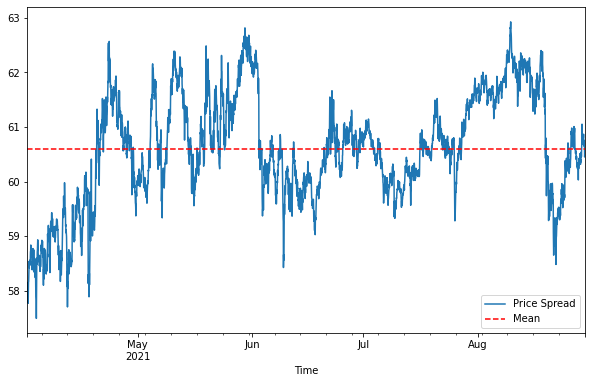

In [130]:
spread.plot() # Plot the spread
plt.axhline(spread.mean(), color='red', linestyle='--') # Add the mean
plt.xlabel('Time')
plt.legend(['Price Spread', 'Mean'])
plt.show()

In [131]:
adf_test(spread, verbose=True)

Results of Dickey-Fuller Test:
Result: The series is  stationary


0.00220215390436203

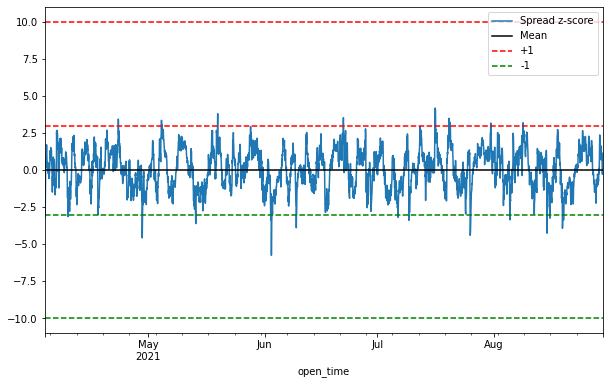

In [132]:
z = zscore(spread, selected['half_life'])
z.dropna(inplace=True)
z.plot()
plt.axhline(0, color='black')
plt.axhline(3, color='red', linestyle='--')
plt.axhline(-3, color='green', linestyle='--')
plt.axhline(10, color='red', linestyle='--')
plt.axhline(-10, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1'])
plt.show()

In [133]:

def read_data(symbol, start_date, end_date):
    df = pd.read_csv(
        f"{DATA_PATH}/{symbol}.csv",
        usecols=["open_time", "open", "high", "low", "close", "volume"],
        parse_dates=["open_time"],
        index_col=["open_time"],
    )
    df = df[(df.index > start_date) & (df.index < end_date)]
    df = df[~df.index.duplicated(keep="first")]
    # df = df.shift(1)
    df.dropna(inplace=True)

    return df

In [134]:
def print_analysis(analyzer):
    """
    Function to print the Technical Analysis results in a nice format.
    """
    # Get the results we are interested in
    total_open = analyzer.total.open
    total_closed = analyzer.total.closed
    total_won = analyzer.won.total
    total_lost = analyzer.lost.total
    win_streak = analyzer.streak.won.longest
    lose_streak = analyzer.streak.lost.longest
    pnl_net = round(analyzer.pnl.net.total, 2)
    strike_rate = (total_won / total_closed) * 100
    # Designate the rows
    h1 = ["Total Open", "Total Closed", "Total Won", "Total Lost"]
    h2 = ["Strike Rate", "Win Streak", "Losing Streak", "PnL Net"]
    r1 = [total_open, total_closed, total_won, total_lost]
    r2 = [strike_rate, win_streak, lose_streak, pnl_net]
    # Check which set of headers is the longest.
    if len(h1) > len(h2):
        header_length = len(h1)
    else:
        header_length = len(h2)
    # Print the rows
    print_list = [h1, r1, h2, r2]
    row_format = "{:<15}" * (header_length + 1)
    print("Trade Analysis Results:")
    for row in print_list:
        print(row_format.format("", *row))

In [135]:
class Strategy(bt.Strategy):
    params = dict(
        symbols=[],
        hedge_ratio=[],
        half_life=None,
        nb_symbols=2,
        sl_upper_limit=10,
        upper_limit=2,
        lower_limit=-2,
        sl_lower_limit=-10,
        position_size=10,
        start_trading_at=None
    )

    def __init__(self) -> None:
        super().__init__()
        self.portfolio = {d._name: d for d in self.datas if d._name in self.p.symbols}
        self.lookback = self.p.half_life
        self.status = 0
        self.in_position = False
        self.dca_count = 0
        self.hedge_ratio = self.p.hedge_ratio
        self.half_life = self.p.half_life
        self.log(f'Start trade with {self.p.symbols}, {self.p.hedge_ratio}, {self.p.half_life}, {self.p.nb_symbols}')

    def log(self, txt, dt=None):
        dt = dt or self.data.datetime[0]
        dt = bt.num2date(dt)
        print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        if order.status in [bt.Order.Submitted, bt.Order.Accepted]:
            return  # Await further notifications

        if order.status == order.Completed:
            if order.isbuy():
                buytxt = f'BUY COMPLETE {order.data._name}, ' \
                         f'price: {order.executed.price:.4f}, ' \
                         f'size: {order.executed.size}, ' \
                         f'cost {order.executed.price * order.executed.size:.4f}'
                self.log(buytxt, order.executed.dt)
            else:
                selltxt = f'SELL COMPLETE {order.data._name}, ' \
                          f'price: {order.executed.price:.4f}, ' \
                          f'size: {order.executed.size}' \
                          f'cost {order.executed.price * order.executed.size:.4f}'
                self.log(selltxt, order.executed.dt)

        elif order.status in [order.Expired, order.Canceled, order.Margin]:
            self.log('Order cancelled %s ,' % order.Status[order.status])
            pass  # Simply log

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.4f, NET %.4f' %
                 (trade.pnl, trade.pnlcomm))
        self.log(f'ACCOUNT VALUE: {self.broker.get_value()}')

    def get_price_series(self, symbol):
        d = self.portfolio[symbol]
        lookback = 6*30
        close = d.close.get(size=lookback)
        t = [bt.num2date(dt) for dt in d.datetime.get(size=lookback)]
        s = pd.Series(np.log(close), index=t)

        return s

    def calculate_spread(self):
        spread = None
        for i in range(self.p.nb_symbols):
            close_s = self.get_price_series(self.p.symbols[i])
            if spread is None:
                spread = close_s * self.hedge_ratio[i]
            else:
                spread += close_s * self.hedge_ratio[i]
        
        spread.dropna(inplace=True)
        return spread 

    def calculate_zscore(self, spread):
        zscore_df = zscore(spread, self.lookback)
        return zscore_df

    def long_spread(self):
        for i, symbol in enumerate(self.p.symbols):
            size = np.sign(self.hedge_ratio[i]) * (self.p.position_size / self.portfolio[symbol].close[0])
            size = ((self.hedge_ratio[i] * self.p.position_size) / self.portfolio[symbol].close[0])
            # size = np.sign(self.hedge_ratio[i]) * (200 / self.portfolio[symbol].close[0])
            if size > 0:
                self.log(f'Buy {symbol}, size = {size}, cost = {self.portfolio[symbol].close[0] * abs(size)}')
                self.buy(data=self.portfolio[symbol], size=abs(size))
            else:
                self.log(f'Sell {symbol}, size = {size}, cost = {self.portfolio[symbol].close[0] * abs(size)}')
                self.sell(data=self.portfolio[symbol], size=abs(size))

    def short_spread(self):
        for i, symbol in enumerate(self.p.symbols):
            size = -np.sign(self.hedge_ratio[i]) * (self.p.position_size / self.portfolio[symbol].close[0])
            size = (-(self.hedge_ratio[i] * self.p.position_size) / self.portfolio[symbol].close[0])
            # size = -np.sign(self.hedge_ratio[i]) * (200 / self.portfolio[symbol].close[0])
            if size > 0:
                self.log(f'Buy {symbol}, size = {size}, cost = {self.portfolio[symbol].close[0] * abs(size)}')
                self.buy(data=self.portfolio[symbol], size=abs(size))
            else:
                self.log(f'Sell {symbol}, size = {size}, cost = {self.portfolio[symbol].close[0] * abs(size)}')
                self.sell(data=self.portfolio[symbol], size=abs(size))

    def close_all(self):
        for i,symbol in enumerate(self.p.symbols):
            self.close(self.portfolio[symbol])
        self.status = 0
        self.in_position = False
        self.dca_count = 0

    def calculate_hedge_ratio(self):
        data = []
        for symbol in self.p.symbols:
            data.append(self.get_price_series(symbol))
        
        df_ = pd.concat(data, axis=1)
        df_.columns = self.p.symbols

        res = test_johansen(df_, self.p.symbols)
        if len(res) == 0:
            return False
        
        res = res[0]
        self.hedge_ratio = res['hedge_ratio']
        
        spread = self.calculate_spread()
        if adf_test(spread, verbose=False) > 0.05:
            return False
        
        self.half_life = cal_half_life(spread)
        self.lookback = self.half_life
        return True

    def next(self):
        dt = self.data.datetime[0]
        dt = bt.num2date(dt)
        if self.p.start_trading_at is not None and dt <= self.p.start_trading_at:
            return

        spread = self.calculate_spread()
        if len(spread) < 6*30:
            return
        
        # if adf_test(spread, verbose=False) > 0.05 and not self.in_position:
        #     self.log(f'Spread is not stationary')
        #     # if not self.calculate_hedge_ratio():
        #     #     return
        #     return
        
        zscore = self.calculate_zscore(spread).iloc[-1]
        if (
            (4 > zscore >= 2)
            and (self.status != 1)
            and not self.in_position
        ):
            self.log(f'Short spread zscore {zscore} > {self.p.upper_limit}')
            self.short_spread()
            self.status = 1  # The current status is "short the spread"
            self.in_position = True
        if (
            (10 > zscore >= 4)
            and (self.status == 1)
            and self.in_position
            and self.dca_count == 0
        ):
            self.log(f'DCA Short spread zscore {zscore} > {self.p.upper_limit}')
            self.short_spread()
            self.dca_count += 1
        elif (
            -4 < zscore < -2
            and (self.status != 2)
            and not self.in_position
        ):
            self.log(f'Long spread zscore {zscore} > {self.p.upper_limit}')
            self.long_spread()
            
            self.status = 2
            self.in_position = True
        elif (
            -10 < zscore <= -4
            and (self.status == 2)
            and not self.in_position
            and self.dca_count == 0
        ):
            self.log(f'DCA Long spread zscore {zscore} > {self.p.upper_limit}')
            self.long_spread()
            self.dca_count += 1
        
        elif self.getposition(self.data0) and (
            (zscore <= 0 and self.status == 1)
            or (zscore >= 0 and self.status == 2)
        ):
            self.log(f'Take profit {zscore} <> 0')
            self.close_all()
        
        elif self.getposition(self.data0) and (
            (zscore >= self.p.sl_upper_limit and self.status == 1)
            or (zscore <= self.p.sl_lower_limit and self.status == 2)
        ):
            self.log(f'Stop Loss {zscore} <> +- 2')
            self.close_all()

# Create a cerebro
cerebro = bt.Cerebro()

# Get the dates from the args
fromdate = datetime.strptime("2021-04-01", "%Y-%m-%d")
todate = datetime.strptime("2021-08-30", "%Y-%m-%d")
start_trading_at = datetime.strptime("2021-06-01", "%Y-%m-%d")

pair = selected['pair']
data = {}
for symbol in pair:
    df_ = read_data(symbol, fromdate, todate)
    # Create the 1st data
    data0 = bt.feeds.PandasData(
        dataname=df_,
        plot=False,
    )

    # Add the 1st data to cerebro
    cerebro.adddata(data0, name=symbol)

# Add the strategy
cerebro.addstrategy(
    Strategy, 
    symbols=pair,
    hedge_ratio=selected['hedge_ratio'],
    half_life=selected['half_life'],
    nb_symbols=len(pair),
    start_trading_at=start_trading_at
)

cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="ta")
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name="return")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)
cerebro.addanalyzer(bt.analyzers.Returns)
cerebro.addanalyzer(bt.analyzers.DrawDown)

# Add the commission - only stocks like a for each operation
cerebro.broker.setcash(1000)

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
# And run it
results = cerebro.run()
first_strat = results[0]
print_analysis(first_strat.analyzers.ta.get_analysis())
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
# Print out the final result
print(
    f"Norm. Annual Return: {results[0].analyzers.returns.get_analysis()['rnorm100']:.2f}%"
)
print(
    f"Max Drawdown: {results[0].analyzers.drawdown.get_analysis()['max']['drawdown']:.2f}%"
)

Starting Portfolio Value: 1000.00
2021-08-29T23:00:00, Start trade with ['BTC-USDT', 'LTC-USDT', 'ALGO-USDT'], [  2.05415654   7.52698081 -13.97296631], 59, 3
2021-06-01T07:00:00, Long spread zscore -2.0704989559144256 > 2
2021-06-01T07:00:00, Buy BTC-USDT, size = 0.0005579304538565622, cost = 20.54156542973221
2021-06-01T07:00:00, Buy LTC-USDT, size = 0.4111082423288882, cost = 75.26980808799614
2021-06-01T07:00:00, Sell ALGO-USDT, size = -151.18985403580953, cost = 139.72966309989516
2021-06-01T08:00:00, BUY COMPLETE BTC-USDT, price: 36817.4400, size: 0.0005579304538565622, cost 20.5416
2021-06-01T08:00:00, BUY COMPLETE LTC-USDT, price: 183.0800, size: 0.4111082423288882, cost 75.2657
2021-06-01T08:00:00, SELL COMPLETE ALGO-USDT, price: 0.9243, size: -151.18985403580953cost -139.7448
2021-06-01T19:00:00, Take profit 0.3712723816403477 <> 0
2021-06-01T20:00:00, SELL COMPLETE BTC-USDT, price: 35969.6100, size: -0.0005579304538565622cost -20.0685
2021-06-01T20:00:00, SELL COMPLETE LTC-U

In [136]:
selected

{'hedge_ratio': array([  2.05415654,   7.52698081, -13.97296631]),
 'sid_1': 'BTC-USDT',
 'sid_2': 'LTC-USDT',
 'sid_3': 'ALGO-USDT',
 'pair': ['BTC-USDT', 'LTC-USDT', 'ALGO-USDT'],
 'half_life': 59}

In [137]:

df1 = get_data(start_trading_at, todate, use_log=False)

In [138]:
p1 = empyrical.cum_returns(df1[pair[0]].pct_change())
p2 = empyrical.cum_returns(df1[pair[1]].pct_change())

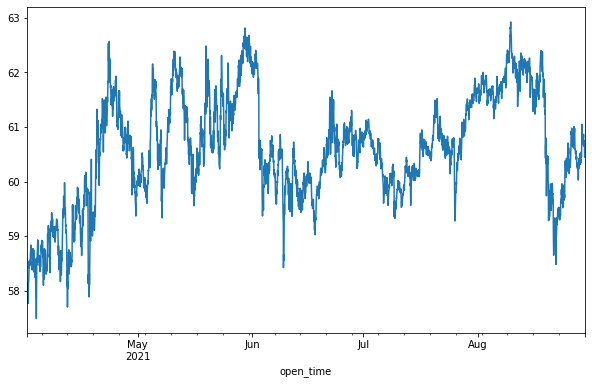

In [139]:

spread.plot()
plt.show()

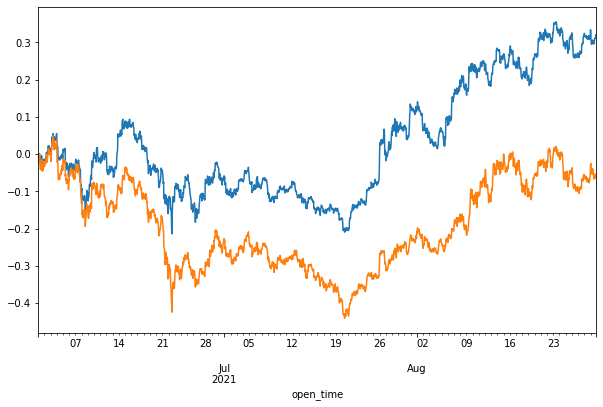

In [140]:

p1.plot()
p2.plot()
plt.show()

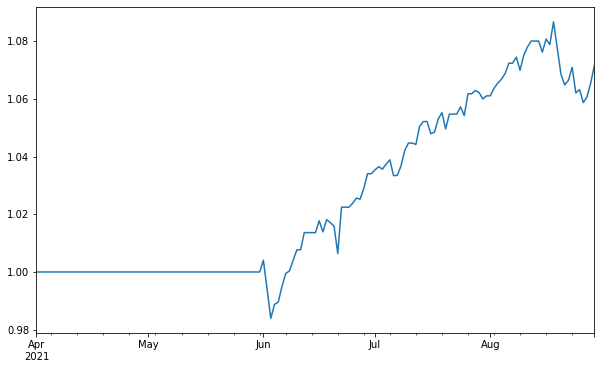

In [141]:
# If no name has been specified, the name is the class name lowercased
return_analyzer = results[0].analyzers.getbyname('return')
# print(tret_analyzer.get_analysis())
account_return = pd.Series(return_analyzer.get_analysis(), name='return')
cum_r = (1 + account_return).cumprod()

cum_r.plot()
plt.show()


## Strategy v2

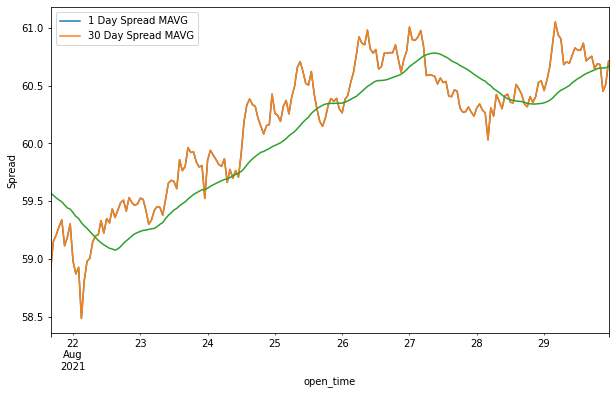

In [142]:
# Get the 1 day moving average of the price spread
spread_mavg1 = spread.rolling(1).mean()
spread_mavg1.name = 'spread 1d mavg'

# Get the 30 day moving average
spread_mavg30 = spread.rolling(30).mean()
spread_mavg30.name = 'spread 30d mavg'

spread.iloc[-200:].plot()

spread_mavg1.iloc[-200:].plot()
spread_mavg30.iloc[-200:].plot()

plt.legend(['1 Day Spread MAVG', '30 Day Spread MAVG'])

plt.ylabel('Spread')
plt.show()

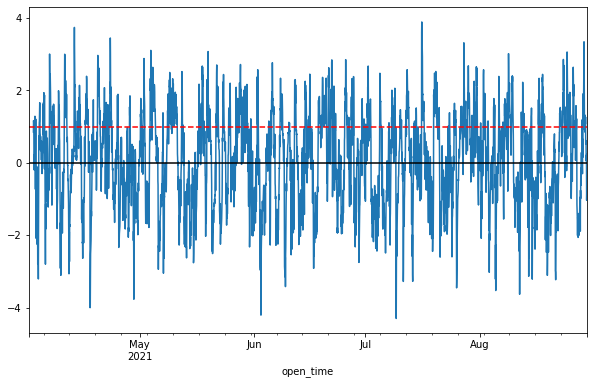

In [143]:
# Take a rolling 30 day standard deviation
std_30 = spread.rolling(30).std()
std_30.name = 'std 30d'

# Compute the z score for each day
zscore_30_1 = (spread_mavg1 - spread_mavg30)/std_30
zscore_30_1.name = 'z-score'
zscore_30_1.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.show()

In [144]:
class Strategy2(Strategy):
    def calculate_zscore(self, spread):
        spread_mavg1 = spread.rolling(1).mean()
        spread_mavg30 = spread.rolling(self.lookback).mean()

        std_30 = spread.rolling(self.lookback).std()
        zscore_30_1 = (spread_mavg1 - spread_mavg30)/std_30
        return zscore_30_1


# Create a cerebro
cerebro = bt.Cerebro()

# Get the dates from the args
fromdate = datetime.strptime("2021-04-01", "%Y-%m-%d")
todate = datetime.strptime("2021-08-30", "%Y-%m-%d")
start_trading_at = datetime.strptime("2021-06-01", "%Y-%m-%d")

pair = selected['pair']
data = {}
for symbol in pair:
    df_ = read_data(symbol, fromdate, todate)
    # Create the 1st data
    data0 = bt.feeds.PandasData(
        dataname=df_,
        plot=False,
    )

    # Add the 1st data to cerebro
    cerebro.adddata(data0, name=symbol)

# Add the strategy
cerebro.addstrategy(
    Strategy2, 
    symbols=pair,
    hedge_ratio=selected['hedge_ratio'],
    half_life=selected['half_life'],
    nb_symbols=len(pair),
    start_trading_at=start_trading_at
)

cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="ta")
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name="return")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)
cerebro.addanalyzer(bt.analyzers.Returns)
cerebro.addanalyzer(bt.analyzers.DrawDown)

# Add the commission - only stocks like a for each operation
cerebro.broker.setcash(1000)

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
# And run it
results = cerebro.run()
first_strat = results[0]
print_analysis(first_strat.analyzers.ta.get_analysis())
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
# Print out the final result
print(
    f"Norm. Annual Return: {results[0].analyzers.returns.get_analysis()['rnorm100']:.2f}%"
)
print(
    f"Max Drawdown: {results[0].analyzers.drawdown.get_analysis()['max']['drawdown']:.2f}%"
)

Starting Portfolio Value: 1000.00
2021-08-29T23:00:00, Start trade with ['BTC-USDT', 'LTC-USDT', 'ALGO-USDT'], [  2.05415654   7.52698081 -13.97296631], 59, 3
2021-06-01T07:00:00, Long spread zscore -2.0528773677478873 > 2
2021-06-01T07:00:00, Buy BTC-USDT, size = 0.0005579304538565622, cost = 20.54156542973221
2021-06-01T07:00:00, Buy LTC-USDT, size = 0.4111082423288882, cost = 75.26980808799614
2021-06-01T07:00:00, Sell ALGO-USDT, size = -151.18985403580953, cost = 139.72966309989516
2021-06-01T08:00:00, BUY COMPLETE BTC-USDT, price: 36817.4400, size: 0.0005579304538565622, cost 20.5416
2021-06-01T08:00:00, BUY COMPLETE LTC-USDT, price: 183.0800, size: 0.4111082423288882, cost 75.2657
2021-06-01T08:00:00, SELL COMPLETE ALGO-USDT, price: 0.9243, size: -151.18985403580953cost -139.7448
2021-06-01T19:00:00, Take profit 0.36811255922740344 <> 0
2021-06-01T20:00:00, SELL COMPLETE BTC-USDT, price: 35969.6100, size: -0.0005579304538565622cost -20.0685
2021-06-01T20:00:00, SELL COMPLETE LTC-

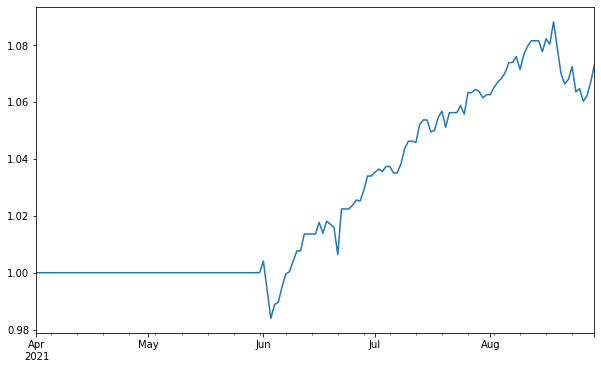

In [145]:
# If no name has been specified, the name is the class name lowercased
return_analyzer = results[0].analyzers.getbyname('return')
# print(tret_analyzer.get_analysis())
account_return = pd.Series(return_analyzer.get_analysis(), name='return')
cum_r = (1 + account_return).cumprod()

cum_r.plot()
plt.show()
